In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Titration curve

The titration curve allows you to determine the pKa of a acid-base couple. For a simple acid-base, the titration curve should be a sigmoid curve and its inflection points (change of sign of second derivatives or extrema of first derivatives) are related to the pKa of the couple.

We read the experimental titration curve.
data from https://www.mathworks.com/matlabcentral/answers/456090-fitting-model-to-titration-data

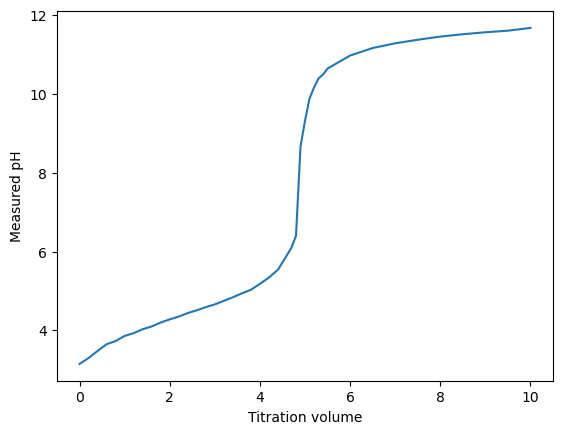

In [2]:
import csv

data=[]
with open('../exercises/Titration.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        data.append(row)
volume = np.array(data[0][1:]).astype(float)
pH = np.array(data[1][1:]).astype(float)

plt.figure()
plt.plot(volume, pH)
plt.xlabel("Titration volume")
plt.ylabel("Measured pH")
plt.show()

From this, compute the first derivative numerically by using the expression

$$ f'(x) \approx \frac{f(x+h) - f(x)}{h}$$

**hint:** use slices!

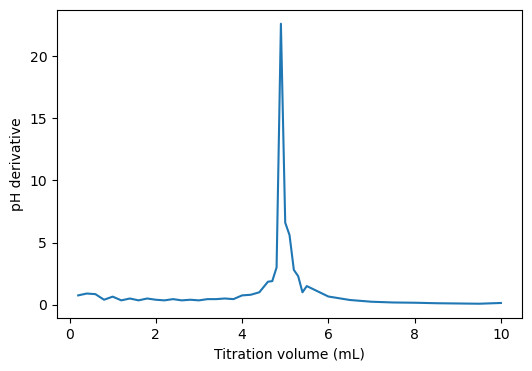

In [3]:
### BEGIN SOLUTION
deriv = (pH[1:] - pH[:-1])/(volume[1:]- volume[:-1])

plt.figure(figsize=(6, 4))
plt.plot(volume[1:], deriv)
plt.xlabel("Titration volume (mL)")
plt.ylabel("pH derivative")
plt.show()
### END SOLUTION

From the derivative, you can now find the equivalence point as the maximum in the derivative. Then the pH at half equivalence point is the pKa of your acid-base couple:

In [4]:
### BEGIN SOLUTION
equivalence = volume[np.argmax(deriv)]
print("equivalence volume = ",equivalence)
print("pKa = ", pH[np.argmax(deriv)//2])
### END SOLUTION

equivalence volume =  4.8
pKa =  4.44


Note that the difference between neighboring points can also be done by using the built-in function numpy.diff for equivalent results.

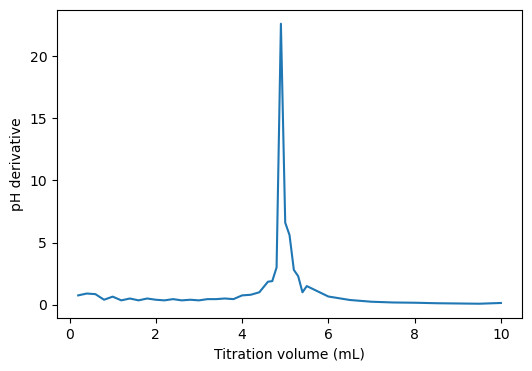

In [5]:
deriv = np.diff(pH)/np.diff(volume)

plt.figure()
plt.plot(volume[1:], deriv)
plt.xlabel("Titration volume (mL)")
plt.ylabel("pH derivative")
plt.show()

# Rate constants

Enzyme kinetics can be described by the Michaelis-Menten kinetics model.

$$ E + S  \underset{k_{-1}}{\overset{k_1}{\rightleftarrows}} ES \overset{k_2}{\rightarrow} E + P $$

The enzyme and substrate first bind in a reversible reaction and then the reaction occurs forming the product and leaving the enzyme intact.

This gives a set of differential equations:

$$ \frac{d[S]}{dt} = -k_1 [E][S] + k_{-1} [ES]$$
$$ \frac{d[E]}{dt} = -k_1 [E][S] + (k_{-1} + k_2) [ES]$$
$$ \frac{d[ES]}{dt} = k_1 [E][S] - (k_{-1} + k_2) [ES]$$
$$ \frac{d[P]}{dt} = k_2 [ES] $$

Let's solve these differential equations by the Euler method, namely simply taking a small timestep and solving $\frac{dA}{dt} = B$ as $A(t+dt) = A(t) + B * dt$.

Use a numpy array of size n_steps for each chemical species, loop over timesteps and propagate the equations. Plot the concentration of each species over time (you can plot E and ES separately since their concentration is usually small).

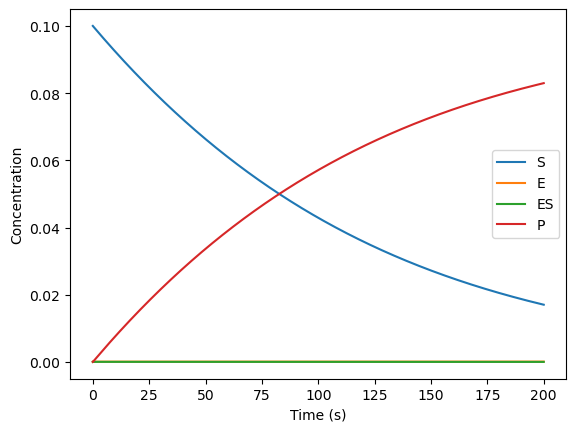

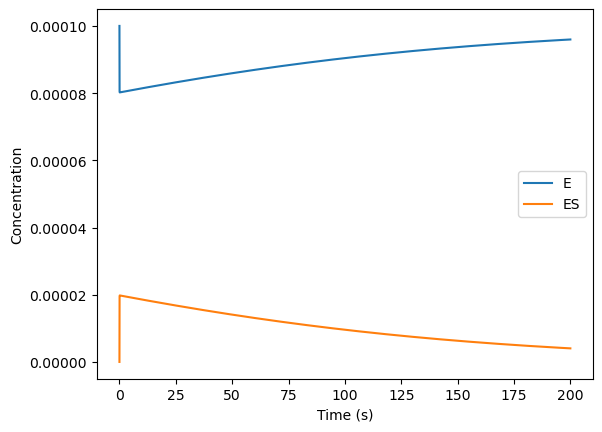

In [52]:
dt = 0.01 # 0.1 s
k1 = 10**2
k_1 = 0.5
k2 = 40
initial_concentrations = [0.1, 10**(-4), 0, 0] # [S], [E], [ES], [P]
nsteps = 20000

### BEGIN SOLUTION
cS = np.zeros(nsteps)
cE = np.zeros(nsteps)
cES = np.zeros(nsteps)
cP = np.zeros(nsteps)
cS[0] = initial_concentrations[0]
cE[0] = initial_concentrations[1]
cES[0] = initial_concentrations[2]
cP[0] = initial_concentrations[3]
for i in range(nsteps-1):
    cS[i+1] = cS[i] + dt* (-k1 * cE[i] * cS[i] + k_1 * cES[i])
    cE[i+1] = cE[i] + dt* (-k1 * cE[i] * cS[i] + (k_1+k2) * cES[i])
    cES[i+1]= cES[i] + dt* ( k1 * cE[i] * cS[i] - (k_1+k2) * cES[i])
    cP[i+1] = cP[i] + dt* (k2 * cES[i])

t = np.arange(nsteps) * dt
plt.figure()
plt.plot(t, cS, label = "S")
plt.plot(t, cE, label = "E")
plt.plot(t, cES, label = "ES")
plt.plot(t, cP, label = "P")
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, cE, label = "E")
plt.plot(t, cES, label = "ES")
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

### END SOLUTION

# Balancing chemical equations (difficult)

We have a challenging chemical equation to balance.

K$_4$Fe(SCN)$_6$ + K$_2$Cr$_2$O$_7$ + H$_2$SO$_4$ →  Fe$_2$(SO$_4$)$_3$ + Cr$_2$(SO$_4$)$_3$ + CO$_2$ + H$_2$O + K$_2$SO$_4$ + KNO$_3$

Let's create a general program to do this using numpy.

First we need to make a list of all unique atoms present here.

Write a function that receives a string and a position (integer) and returns the atom which starts at this position in the string. For this simply check if the current position is an upper case letter and if the next position in the string has a lower case letter. Return the resulting atom name. If the character at this position does not correspond to an atom, return an empty string.

In [6]:
### BEGIN SOLUTION
def get_atom(string, i):
    atom = ""
    if string[i].isupper():
        atom = string[i]
        if i+1 < len(string):
            if string[i+1].islower():
                atom+= string[i+1]
    return atom
### END SOLUTION

assert get_atom("K2Cr2O7",0) == "K"
assert get_atom("K2Cr2O7",1) == ""
assert get_atom("K2Cr2O7",2) == "Cr"
assert get_atom("K2Cr2O7",3) == ""
assert get_atom("K2Cr2O7",5) == "O"
assert get_atom("H2O",0) == "H"
assert get_atom("H2O",2) == "O"

Now simply loop through the character positions in the equation below, use your function above and store the atoms in a set.

In [7]:
equation = "K4Fe(SCN)6 + K2Cr2O7 + H2SO4 =  Fe2(SO4)3 + Cr2(SO4)3 + CO2 + H2O + K2SO4 + KNO3"

def get_unique_atom_list(equation):
    unique_atom_set = set()
    ### BEGIN SOLUTION

    for i in range(len(equation)):
        atom = get_atom(equation, i)
        if len(atom)>0:
            unique_atom_set.add(atom)
    ### END SOLUTION
    return unique_atom_set


assert get_unique_atom_list(equation) == {'C', 'S', 'N', 'Cr', 'H', 'O', 'K', 'Fe'}

Double check that both sides of the equal have the same list of atoms.

**Hint:** use the string split function

In [8]:
### BEGIN SOLUTION
left, right = equation.split("=")
print(get_unique_atom_list(left))
print(get_unique_atom_list(right))
print(get_unique_atom_list(left) == get_unique_atom_list(right))
### END SOLUTION

{'K', 'Cr', 'Fe', 'O', 'H', 'N', 'S', 'C'}
{'K', 'Cr', 'Fe', 'O', 'H', 'N', 'S', 'C'}
True


Now we will describe each molecule in the equation as an array of size N with N the total number of unique atoms you found. Each number in this array will correspond to the number of this specific atom that the given molecule has. Example:

if we have atoms C, O, N, H, Fe, then:
* NH3 will be represented as [0, 0, 1, 3, 0]
* H2O will be represented as [0, 1, 0, 2, 0]
* Fe(CO)6 will be represented as [6, 6, 0, 0, 1]

There are many ways to do this, but here is a suggestion:
* Split the equation in individual molecules and loop over these molecules
* For each molecule create a zero array of the right size.
* Go through the string, find the atoms and check if there is a number associated to it.
* if the current position is a parenthesis, look for the end of the parenthesis using "find" and the associated number
* Add the number (or 1) to the array at a position which depends on the atom
* store the arrays into a list.

For simplicity, we will assume that all numbers are single digit and that there is at most a single parenthesis pair in the molecule.

In [9]:
atom_list = list(get_unique_atom_list(equation))
n_atoms = len(atom_list)
molecule_list = []
for molecule in left.split("+") + right.split("+"):
    array = np.zeros(n_atoms)
    ### BEGIN SOLUTION
    molecule = molecule.strip()
    factor = 1
    for i in range(len(molecule)):
        
        # Handle parenthesis
        if molecule[i] == "(":
            factor = int(molecule[molecule.find(")")+1])
        if molecule[i] == ")":
            factor = 1

        # Get atom and number
        atom = get_atom(molecule, i)
        n = len(atom)
        if n>0:
            number = 1
            if i+n < len(molecule):
                if molecule[i+n].isnumeric():
                    number = int(molecule[i+n])
            number *= factor
            array[atom_list.index(atom)] = number
        ### END SOLUTION
    molecule_list.append(array)

Having done this, we have actually formed a linear system of equation

$$ x_0 A_0 + x_1 A_1 + ... = 0  $$

This is indeed what we want assuming we wrote the `left = right` chemical equation as `left - right = 0`

This can also be understood as a matrix equation AX = 0.

There are of course an infinite number of solutions to this problem which are multiples of each other. So we instead choose that $x_0 = 1$. For this we simply move it to the right and solve

$$ x_1 A_1 + ... = -A_0  $$

This gives us exactly 8 equations and 8 unknown. We can now use numpy.linalg.solve which is precisely meant to solve these types of equations.

Note: if we had not had the same number of equations and unknowns we could have used numpy.linalg.lstsq which tries to find the best solution to the system.

In [10]:
A = np.array(molecule_list).T
solution = np.linalg.solve(A[:,1:],-A[:,0])
print(solution)

[ 16.16666667  59.16666667  -0.5        -16.16666667  -6.
 -59.16666667 -15.16666667  -6.        ]


We see that the last numbers are negative, but this is normal since we are solving `left - right = 0`. Once back to the right, they will be back to positive.

But a second unfortunate problem is that our solution is not integer. It is still a valid solution, but we would prefer an integer solution. We notice many "0.166666667" and so we have a good hope that multiplying by 6 will give integer results (this corresponds to setting $c_0$ = 6) 

In [11]:
print(solution*6)

[  97.  355.   -3.  -97.  -36. -355.  -91.  -36.]


This gives us our final equation

6 K$_4$Fe(SCN)$_6$ + 97 K$_2$Cr$_2$O$_7$ + 355 H$_2$SO$_4$ →  3 Fe$_2$(SO$_4$)$_3$ + 97 Cr$_2$(SO$_4$)$_3$ + 36 CO$_2$ + 355 H$_2$O + 91 K$_2$SO$_4$ + 36 KNO$_3$


which you can indeed check is balanced!